# TP : Sentiment analysis on IMDB movie reviews

### João Lucas Furtado Melga
### Leonardo Hannas de Carvalho Santos

## Objectives

1. Implement a simple way to represent text data - Bag of words
2. Implement a basic statistical learning model - Bayesian Naive
3. Use these representations and this model for a sentiment analysis task.
4. Experiment with various way to reduce the vocabulary size and look at the distribution obtained.

## Necessary dependancies

We will need the following packages:
- The Machine Learning API Scikit-learn : http://scikit-learn.org/stable/install.html
- The Natural Language Toolkit : http://www.nltk.org/install.html

Both are available with Anaconda: https://anaconda.org/anaconda/nltk and https://anaconda.org/anaconda/scikit-learn

In [1]:
import os.path as op
import re 
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to C:\Users\João
[nltk_data]     Melga\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## Loading data

We retrieve the textual data in the variable *texts*.

The labels are retrieved in the variable $y$ - it contains *len(texts)* of them: $0$ indicates that the corresponding review is negative while $1$ indicates that it is positive.

In [3]:
from glob import glob

# We get the files from the path: ./aclImdb/train/neg for negative reviews, and ./aclImdb/train/pos for positive reviews
train_filenames_neg = sorted(glob(op.join('.', 'aclImdb', 'train', 'neg', '*.txt')))
train_filenames_pos = sorted(glob(op.join('.', 'aclImdb', 'train', 'pos', '*.txt')))

# Each files contains a review that consists in one line of text: we put this string in two lists, that we concatenate
train_texts_neg = [open(f, encoding="utf8").read() for f in train_filenames_neg]
train_texts_pos = [open(f, encoding="utf8").read() for f in train_filenames_pos]
train_texts = train_texts_neg + train_texts_pos

# The first half of the elements of the list are string of negative reviews, and the second half positive ones
# We create the labels, as an array of [1,len(texts)], filled with 1, and change the first half to 0
train_labels = np.ones(len(train_texts), dtype=int)
train_labels[:len(train_texts_neg)] = 0.

In [4]:
open("./aclImdb/train/neg/0_3.txt", encoding="utf8").read()

"Story of a man who has unnatural feelings for a pig. Starts out with a opening scene that is a terrific example of absurd comedy. A formal orchestra audience is turned into an insane, violent mob by the crazy chantings of it's singers. Unfortunately it stays absurd the WHOLE time with no general narrative eventually making it just too off putting. Even those from the era should be turned off. The cryptic dialogue would make Shakespeare seem easy to a third grader. On a technical level it's better than you might think with some good cinematography by future great Vilmos Zsigmond. Future stars Sally Kirkland and Frederic Forrest can be seen briefly."

**In this lab, the impact of our choice of representations upon our results will also depend on the quantity of data we use:** try to see how changing the parameter ```k``` affects our results !

In [5]:
# This number of documents may be high for most computers: we can select a fraction of them (here, one in k)
# Use an even number to keep the same number of positive and negative reviews
k = 10
train_texts_reduced = train_texts[0::k]
train_labels_reduced = train_labels[0::k]
print('Number of documents:', len(train_texts_reduced))

Number of documents: 2500


We can use a function from sklearn, ```train_test_split```, to separate data into training and validation sets:

In [6]:
from sklearn.model_selection import train_test_split

In [7]:
train_texts_splt, val_texts, train_labels_splt, val_labels = train_test_split(train_texts_reduced, 
                                                                              train_labels_reduced, 
                                                                              test_size=.2, 
                                                                              random_state=1)

## I - Adapted representation of documents

Our statistical model, like most models applied to textual data, uses counts of word occurrences in a document. Thus, a very convenient way to represent a document is to use a Bag-of-Words (BoW) vector, containing the counts of each word (regardless of their order of occurrence) in the document. 

If we consider the set of all the words appearing in our $T$ training documents, which we note $V$ (Vocabulary), we can create **an index**, which is a bijection associating to each $w$ word an integer, which will be its position in $V$. 

Thus, for a document extracted from a set of documents containing $|V|$ different words, a BoW representation will be a vector of size $|V|$, whose value at the index of a word $w$ will be its number of occurrences in the document. 

We can use the **CountVectorizer** class from scikit-learn to obtain these representations:

In [8]:
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.model_selection import cross_val_score
from sklearn.base import BaseEstimator, ClassifierMixin

In [9]:
# Function to print the corpus (set of texts)
def print_corpus(corpus):
    print("Corpus:")
    print("[", end="")
    for i, string in enumerate(corpus):
        if i == len(corpus) - 1:
            print(f"'{string}'", end="]\n")
        else:
            print(f"'{string}',", end="\n")

In [10]:
corpus = ['I walked down down the boulevard',
          'I walked down the avenue',
          'I ran down the boulevard',
          'I walk down the city',
          'I walk down the the avenue']
vectorizer = CountVectorizer()

Bow = vectorizer.fit_transform(corpus)

print_corpus(corpus)
print("\n",vectorizer.get_feature_names_out())
Bow.toarray()

Corpus:
['I walked down down the boulevard',
'I walked down the avenue',
'I ran down the boulevard',
'I walk down the city',
'I walk down the the avenue']

 ['avenue' 'boulevard' 'city' 'down' 'ran' 'the' 'walk' 'walked']


array([[0, 1, 0, 2, 0, 1, 0, 1],
       [1, 0, 0, 1, 0, 1, 0, 1],
       [0, 1, 0, 1, 1, 1, 0, 0],
       [0, 0, 1, 1, 0, 1, 1, 0],
       [1, 0, 0, 1, 0, 2, 1, 0]], dtype=int64)

We display the list containing the words ordered according to their index (Note that words of 2 characters or less are not counted).

### Preprocessing the text: get the BoW representations ##

The first thing to do is to turn the review from a string into a list of words. The simplest method is to divide the string according to spaces with the command:
``text.split()``

But we must also be careful to remove special characters that may not have been cleaned up (such as HTML tags if the data was obtained from web pages). Since we're going to count words, we'll have to build a list of tokens appearing in our data. In our case, we'd like to reduce this list and make it uniform (ignore capitalization, punctuation, and the shortest words). 
We will therefore use a function adapted to our needs - but this is a job that we generally don't need to do ourselves, since there are many tools already adapted to most situations. 
For text cleaning, there are many scripts, based on different tools (regular expressions, for example) that allow you to prepare data. The division of the text into words and the management of punctuation is handled in a step called *tokenization*; if needed, a python package like NLTK contains many different *tokenizers*.

In [11]:
# We might want to clean the file with various strategies:
def clean_and_tokenize(text):
    """
    Cleaning a document with:
        - Lowercase        
        - Removing numbers with regular expressions
        - Removing punctuation with regular expressions
        - Removing other artifacts
    And separate the document into words by simply splitting at spaces
    Params:
        text (string): a sentence or a document
    Returns:
        tokens (list of strings): the list of tokens (word units) forming the document
    """        
    # Lowercase
    text = text.lower()
    # Remove numbers
    text = re.sub(r"[0-9]+", "", text)
    # Remove punctuation
    REMOVE_PUNCT = re.compile("[.;:!\'?,\"()\[\]]")
    text = REMOVE_PUNCT.sub("", text)
    # Remove small words (1 and 2 characters)
    text = re.sub(r"\b\w{1,2}\b", "", text)
    # Remove HTML artifacts specific to the corpus we're going to work with
    REPLACE_HTML = re.compile("(<br\s*/><br\s*/>)|(\-)|(\/)")
    text = REPLACE_HTML.sub(" ", text)
    
    tokens = text.split()        
    return tokens

# Or we might want to use an already-implemented tool. The NLTK package has a lot of very useful text processing tools, among them various tokenizers
# Careful, NLTK was the first well-documented NLP package, but it might be outdated for some uses. Check the documentation !
from nltk.tokenize import word_tokenize

corpus_raw = "I walked down down the boulevard. I walked down the avenue. I ran down the boulevard. I walk down the city. I walk down the the avenue."
print(clean_and_tokenize(corpus_raw))
print(word_tokenize(corpus_raw))

['walked', 'down', 'down', 'the', 'boulevard', 'walked', 'down', 'the', 'avenue', 'ran', 'down', 'the', 'boulevard', 'walk', 'down', 'the', 'city', 'walk', 'down', 'the', 'the', 'avenue']
['I', 'walked', 'down', 'down', 'the', 'boulevard', '.', 'I', 'walked', 'down', 'the', 'avenue', '.', 'I', 'ran', 'down', 'the', 'boulevard', '.', 'I', 'walk', 'down', 'the', 'city', '.', 'I', 'walk', 'down', 'the', 'the', 'avenue', '.']


The next function takes as input a list of documents (each in the form of a string) and returns, as in the example using ``CountVectorizer``:
- A vocabulary that associates, to each word encountered, an index
- A matrix, with rows representing documents and columns representing words indexed by the vocabulary. In position $(i,j)$, one should have the number of occurrences of the word $j$ in the document $i$.

The vocabulary, which was in the form of a *list* in the previous example, can be returned in the form of a *dictionary* whose keys are the words and values are the indices. Since the vocabulary lists the words in the corpus without worrying about their number of occurrences, it can be built up using a set (in python).

<div class='alert alert-block alert-info'>
            Code:</div>

In [12]:
def count_words(texts):
    """
    Vectorize text : return count of each word in the text snippets

    Parameters
    ----------
    texts : list of str
        The texts
    Returns
    -------
    vocabulary : dict
        A dictionary that points to an index in counts for each word.
    counts : ndarray, shape (n_samples, n_features)
        The counts of each word in each text.
    """
    
    # List of all words in the texts
    words = []
    for text in texts:
        # Clean and tokenize the text
        tokens = clean_and_tokenize(text)
        # Add the list of tokens to the list of words
        words.append(tokens)
 
    # Flatten the list of lists into a single list of words
    flat_words = [token for sublist in words for token in sublist]
    
    # Creation of the set of all words in the texts, removing repetitions
    words = set(flat_words)
    
    # Creation of the vocabulary
    vocabulary = {}
    for word in words:
        vocabulary[word] = len(vocabulary)
    
    # Creation of the Count Matrix
    counts = np.zeros((len(texts), len(vocabulary)))
    for i, text in enumerate(texts):
        tokens = clean_and_tokenize(text)
        for token in tokens:
            counts[i, vocabulary[token]] += 1
    
    return vocabulary, counts

In [13]:
Voc, X = count_words(corpus)
print_corpus(corpus)
print("\nVocabulary:\n", Voc)
print("\nCounts:\n", X)

Corpus:
['I walked down down the boulevard',
'I walked down the avenue',
'I ran down the boulevard',
'I walk down the city',
'I walk down the the avenue']

Vocabulary:
 {'city': 0, 'walk': 1, 'ran': 2, 'boulevard': 3, 'the': 4, 'walked': 5, 'down': 6, 'avenue': 7}

Counts:
 [[0. 0. 0. 1. 1. 1. 2. 0.]
 [0. 0. 0. 0. 1. 1. 1. 1.]
 [0. 0. 1. 1. 1. 0. 1. 0.]
 [1. 1. 0. 0. 1. 0. 1. 0.]
 [0. 1. 0. 0. 2. 0. 1. 1.]]


Now, if we want to represent text that was not available when building the vocabulary, we will not be able to represent **new words** ! Let's take a look at how `CountVectorizer` does it:

In [14]:
val_corpus = ['I walked up the street']
Bow = vectorizer.transform(val_corpus)
Bow.toarray()

array([[0, 0, 0, 0, 0, 1, 0, 1]], dtype=int64)

Given that the vocabulary is solely composed of the following words,
```python
['avenue' 'boulevard' 'city' 'down' 'ran' 'the' 'walk' 'walked']
```
new words will not be represented in the BoW vector, such as ```up``` and ```street```.


Modify the ```count_words``` function to be able to deal with new documents when given a previously obtained vocabulary ! 

<div class='alert alert-block alert-info'>
            Code:</div>

In [15]:
def count_words(texts, voc = None):
    """
    Vectorize text : return count of each word in the text snippets

    Parameters
    ----------
    texts : list of str
        The texts
    voc : dict
        A dictionary that points to an index in counts for each word - output by a previous use of the function
        If not None, use this one
    Returns
    -------
    vocabulary : dict
        A dictionary that points to an index in counts for each word.
    counts : ndarray(n_samples, n_features)
        The counts of each word in each text.
    """
    
    if voc == None:
        vocabulary = {}
         
        # List of all words in the texts
        words = []
        for text in texts:
            # Clean and tokenize the text
            tokens = clean_and_tokenize(text)
            # Add the list of tokens to the list of words
            words.append(tokens)

        # Flatten the list of lists into a single list of words
        flat_words = [token for sublist in words for token in sublist]
        
        # Creation of the set of all words in the texts
        words = set(flat_words)
        
        # Creation of the vocabulary
        for word in words:
            if word not in vocabulary:
                vocabulary[word] = len(vocabulary)
    else:
        vocabulary = voc
    
    # Creation of the Count Matrix
    counts = np.zeros((len(texts), len(vocabulary)))
    for i, text in enumerate(texts):
        tokens = clean_and_tokenize(text)
        for token in tokens:
            if token in vocabulary:
                counts[i, vocabulary[token]] += 1
        
    
    return vocabulary, counts

In [16]:
Voc, X = count_words(corpus)
print_corpus(corpus)
print("\nVocabulary:\n", Voc)
print("\nCounts:\n", X)

print("\n","-" * 100)

new_corpus = ['I walked up the street']
print("\nNew Corpus:\n", new_corpus)
newVoc, newX = count_words(new_corpus, voc=Voc)
print("\nNew Vocabulary:\n", newVoc)
print("\nNew Counts:\n", newX)

Corpus:
['I walked down down the boulevard',
'I walked down the avenue',
'I ran down the boulevard',
'I walk down the city',
'I walk down the the avenue']

Vocabulary:
 {'city': 0, 'walk': 1, 'ran': 2, 'boulevard': 3, 'the': 4, 'walked': 5, 'down': 6, 'avenue': 7}

Counts:
 [[0. 0. 0. 1. 1. 1. 2. 0.]
 [0. 0. 0. 0. 1. 1. 1. 1.]
 [0. 0. 1. 1. 1. 0. 1. 0.]
 [1. 1. 0. 0. 1. 0. 1. 0.]
 [0. 1. 0. 0. 2. 0. 1. 1.]]

 ----------------------------------------------------------------------------------------------------

New Corpus:
 ['I walked up the street']

New Vocabulary:
 {'city': 0, 'walk': 1, 'ran': 2, 'boulevard': 3, 'the': 4, 'walked': 5, 'down': 6, 'avenue': 7}

New Counts:
 [[0. 0. 0. 0. 1. 1. 0. 0.]]


<div class='alert alert-block alert-warning'>
            Question:</div>                       

**Careful:** 

Check the size that the representations are going to have (given the way they are build). What does this imply for the memory use ? What ```CountVectorizer``` argument allows to avoid the issue ?
 

**Answer:** 

When using CountVectorizer in Python's scikit-learn library, the size of the representations can become quite large, especially when dealing with large text data. This can lead to high memory usage, which can be a problem in systems with limited resources. To mitigate this issue, CountVectorizer uses a sparse matrix representation by default. A sparse matrix is a matrix in which most of the elements are zero. Instead of storing all the zeros, a sparse matrix only stores the locations and values of the non-zero elements, which can save a significant amount of memory.

As in count_words we are using different methods to filter, tokenize and store the data (for instance, we are not using the sparse matrix properties to optimize the storage), so we got different sizes of the vocabulary when comparing the CountVectorizer and count_words results.

<div class='alert alert-block alert-info'>
            Code:</div>

In [17]:
voc, train_bow = count_words(train_texts_splt)
print(train_bow.shape)

(2000, 29378)


In [18]:
_, val_bow = count_words(val_texts, voc)
print(val_bow.shape)

(500, 29378)


In [19]:
# Do the same with a CountVectorizer: create and fit the vectorizer to the training data
vectorizer = CountVectorizer()
vectorizer_train_bow = vectorizer.fit_transform(train_texts_splt).toarray()

print(vectorizer_train_bow.shape)

(2000, 25410)


In [20]:
# Transform the validation data
vectorizer_val_bow = vectorizer.transform(val_texts).toarray()
print(vectorizer_val_bow.shape)

(500, 25410)


## II- Naive Bayesian 

### Main idea

A movie review is in fact a list of words $s = (w_1, ..., w_N)$, and we try to find the associated class $c$ - which in our case may be $c = 0$ or $c = 1$. The objective is thus to find for each review $s$ the class $\hat{c}$ maximizing the conditional probability **$P(c|s)$** : 

$$\hat{c} = \underset{c}{\mathrm{argmax}}\, P(c|s) = \underset{c}{\mathrm{argmax}}\,\frac{P(s|c)P(c)}{P(s)}$$

**Hypothesis : P(s) is constant for each class** :

$$\hat{c} = \underset{c}{\mathrm{argmax}}\,\frac{P(s|c)P(c)}{P(s)} = \underset{c}{\mathrm{argmax}}\,P(s|c)P(c)$$

**Naive hypothesis : the variables (words) of a review are independant between themselves** : 

$$P(s|c) = P(w_1, ..., w_N|c)=\Pi_{i=1..N}P(w_i|c)$$

### General view

#### Training: Estimating the probabilities

For each word $w$ in the vocabulary $V$, $P(w|c)$ is the number of occurrences of $w$ in all reviews of class $c$, divided by the total number of occurrences in $c$. If we note $T(w,c)$ this number of occurrences, we get:

$$P(w|c) = \text{Frequency of }w\text{ in }c = \frac{T(w,c)}{\sum_{w' \in V} T(w',c)}$$

#### Test: Calculating scores

To facilitate the calculations and to avoid *underflow* and approximation errors, we use the log-sum trick, and we pass the equation into log-probabilities : 

$$ \hat{c} = \underset{c}{\mathrm{argmax}} P(c|s) = \underset{c}{\mathrm{argmax}} \left[ \mathrm{log}(P(c)) + \sum_{i=1..N}log(P(w_i|c)) \right] $$

#### Laplace smoothing

A word that does not appear in a document has a probability of zero: this will cause issues with the logarithm. So we keep a very small part of the probability mass that we redistribute with the *Laplace smoothing*: 

$$P(w|c) = \frac{T(w,c) + 1}{\sum_{w' \in V} (T(w',c) + 1)}$$

There are other smoothing methods, generally suitable for other, more complex applications. 

### Detail: training

The idea is to extract the number of occurrences $T(w,c)$ for each word $w$ and each class $c$, which will make it possible to calculate the matrix of conditional probabilities $\pmb{P}$ such that: $$\pmb{P}_{w,c} = P(w|c)$$

Note that the number of occurrences $T(w,c)$ can be easily obtained from the BoW representations of all documents !

#### Procedure:

- Extract the vocabulary $V$ and counts $T(w,c)$ for each of the words $w$ and classes $c$, from a set of documents.
- Calculate the a priori probabilities of the classes $P(c) = \frac{|\text{documents in class }c|}{|\text{all documents}|}$
- Calculate the conditional **smoothed** probabilities $P(w|c) = \frac{T(w,c) + 1}{\sum_{w' \in V} T(w',c) + 1}$.

### Detail: test

We now know the conditional probabilities given by the $\pmb{P}$ matrix. 
Now we must obtain $P(s|c)$ for the current document. This quantity is obtained using a simple calculation involving the BoW representation of the document and $\pmb{P}$.

#### Procedure:

- For each of the classes $c$,
    - $Score(c) = \log P(c)$
    - For each word $w$ in the document to be tested:
        - $Score(c) += \log P(w|c)$
- Return $argmax_{c \in C} Score(c)$ 

We will therefore be able to use the reviews at our disposal to **estimate the probabilities $P(w|c)$ for each word $w$ given the two classes $c$**. These reviews will allow us to learn how to evaluate the "compatibility" between words and classes.
```python
def fit(self, X, y)
``` 
**Training**: will learn a statistical model based on the representations $X$ corresponding to the labels $y$.
Here, $X$ contains representations obtained as the output of ```count_words```. You can complete the function using the procedure detailed above. 

Note: the smoothing is not necessarily done with a $1$ - it can be done with a positive value $\alpha$, which we can implement as an argument of the class "NB".

```python
def predict(self, X)
```
**Testing**: will return the labels predicted by the model for other representations $X$.

<div class='alert alert-block alert-info'>
            Code:</div>

In [21]:
class NB(BaseEstimator, ClassifierMixin):
    # Les arguments de classe permettent l'héritage de classes de sklearn
    def __init__(self, alpha=1.0):
        # alpha is the smoothing parameter: it corresponds to line 10 of the training algorithm
        # By default, we use alpha = 1
        self.alpha = alpha

    def fit(self, X, y):
        # Count the number of documents and the number of classes
        self.class_count_ = np.unique(y, return_counts=True)[1]
        n_classes = len(self.class_count_)
        n_features = X.shape[1]
        self.classes_ = np.unique(y)
        
        # Initialize log prior and log likelihoods
        self.log_prior_ = np.log(self.class_count_ / len(y))
        self.feature_counts_ = np.zeros((n_classes, n_features))
        self.feature_log_prob_ = np.zeros((n_classes, n_features))
        
        # Count features in documents for each class
        for class_index, class_ in enumerate(self.classes_):
            X_class = X[y == class_]
            self.feature_counts_[class_index, :] = X_class.sum(axis=0) + self.alpha  # Apply Laplace smoothing
        
        # Compute the log likelihood of the features given a class
        self.feature_log_prob_ = (np.log(self.feature_counts_) - 
                                  np.log(self.feature_counts_.sum(axis=1).reshape(-1, 1)))
        
        return self

    def predict(self, X):
        joint_log_likelihood = np.dot(X, self.feature_log_prob_.T) + self.log_prior_
        predicted_classes = np.argmax(joint_log_likelihood, axis=1)
        return self.classes_[predicted_classes]

    def score(self, X, y):
        return np.mean(self.predict(X) == y)

## III - Experimentation

Experiment on this model with your own representations. **Visualize** the results with the following tools, and **compare with the representations of ```CountVectorizer```/ Naïve Bayes model of scikit-learn ```MultinomialNB```:**

<div class='alert alert-block alert-info'>
            Code:</div>

In [22]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.naive_bayes import MultinomialNB

In the following cells we did four combinations of 2 different Naive Bayes methods and 2 different Bag-of-World generators.

* Our `Naïve Bayes` (NB) with `count_words`:

Accuracy with count_words:  0.806
Report:
              precision    recall  f1-score   support

           0       0.77      0.85      0.81       242
           1       0.85      0.76      0.80       258

    accuracy                           0.81       500
   macro avg       0.81      0.81      0.81       500
weighted avg       0.81      0.81      0.81       500



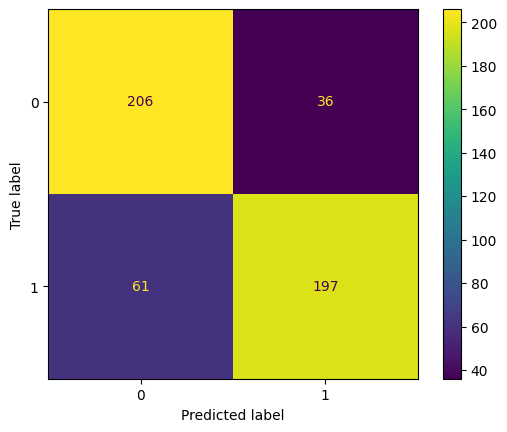

In [23]:
# Fit the model on the training data
NB_model_cw = NB()
NB_model_cw.fit(train_bow, train_labels_splt)

# Test it on the validation data
score = NB_model_cw.score(val_bow, val_labels)
print('Accuracy with count_words: ', score)

y_predicted = NB_model_cw.predict(val_bow)

confusion_mat = confusion_matrix(val_labels, y_predicted)
ConfusionMatrixDisplay(confusion_mat).plot()

report = classification_report(val_labels, y_predicted)
print('Report:')
print(report)

* Our `Naïve Bayes` (NB) with `CountVectorizer`:

Accuracy with count_words:  0.788
Report:
              precision    recall  f1-score   support

           0       0.75      0.84      0.79       242
           1       0.83      0.74      0.78       258

    accuracy                           0.79       500
   macro avg       0.79      0.79      0.79       500
weighted avg       0.79      0.79      0.79       500



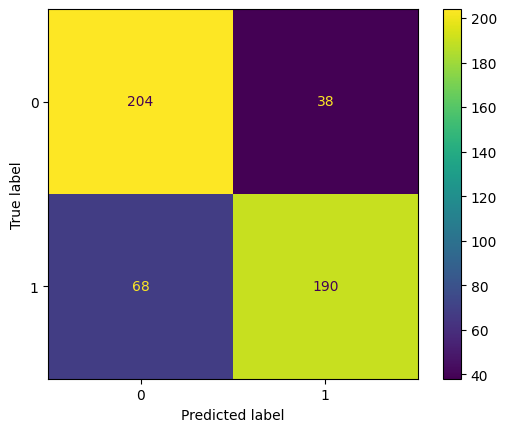

In [24]:
# Fit the model on the training data
NB_model_cv = NB()
NB_model_cv.fit(vectorizer_train_bow, train_labels_splt)

# Test it on the validation data
score = NB_model_cv.score(vectorizer_val_bow, val_labels)
print('Accuracy with count_words: ', score)

y_predicted = NB_model_cv.predict(vectorizer_val_bow)

confusion_mat = confusion_matrix(val_labels, y_predicted)
ConfusionMatrixDisplay(confusion_mat).plot()

report = classification_report(val_labels, y_predicted)
print('Report:')
print(report)

* `MultinomialNB` with `count_words`:

Accuracy with count_words:  0.806
Report:
              precision    recall  f1-score   support

           0       0.75      0.84      0.79       242
           1       0.83      0.74      0.78       258

    accuracy                           0.79       500
   macro avg       0.79      0.79      0.79       500
weighted avg       0.79      0.79      0.79       500



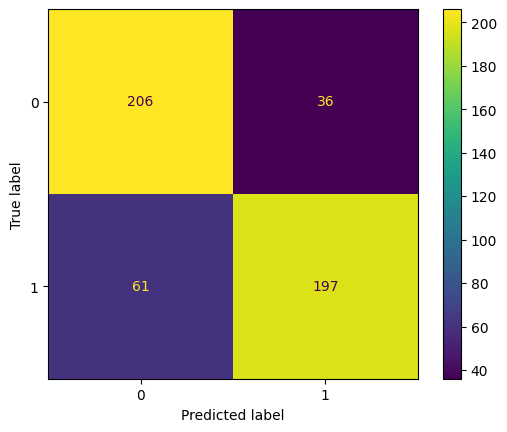

In [25]:
# Fit the model on the training data
multinomia_NB_model_cw = MultinomialNB()
multinomia_NB_model_cw.fit(train_bow, train_labels_splt)

# Test it on the validation data
multinomia_score = multinomia_NB_model_cw.score(val_bow, val_labels)
print('Accuracy with count_words: ', multinomia_score)

multinomia_y_predicted = multinomia_NB_model_cw.predict(val_bow)

multinomia_confusion_mat = confusion_matrix(val_labels, multinomia_y_predicted)
ConfusionMatrixDisplay(multinomia_confusion_mat).plot()

multinomia_report = classification_report(val_labels, multinomia_y_predicted)
print('Report:')
print(report)

* `MultinomialNB` with `CountVectorizer`:

Accuracy with count_words:  0.788
Report:
              precision    recall  f1-score   support

           0       0.75      0.84      0.79       242
           1       0.83      0.74      0.78       258

    accuracy                           0.79       500
   macro avg       0.79      0.79      0.79       500
weighted avg       0.79      0.79      0.79       500



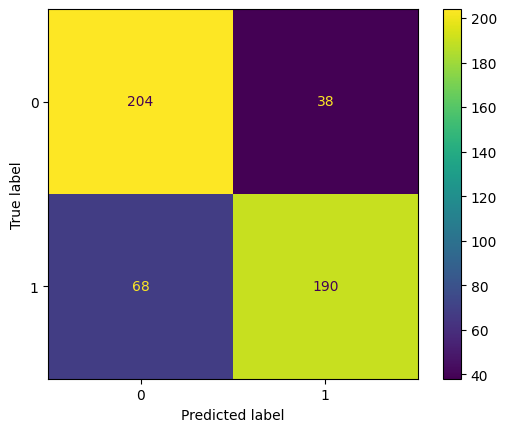

In [26]:
# Fit the model on the training data
multinomia_NB_model_cv = MultinomialNB()
multinomia_NB_model_cv.fit(vectorizer_train_bow, train_labels_splt)

# Test it on the validation data
multinomia_score = multinomia_NB_model_cv.score(vectorizer_val_bow, val_labels)
print('Accuracy with count_words: ', multinomia_score)

multinomia_y_predicted = multinomia_NB_model_cv.predict(vectorizer_val_bow)

multinomia_confusion_mat = confusion_matrix(val_labels, multinomia_y_predicted)
ConfusionMatrixDisplay(multinomia_confusion_mat).plot()

multinomia_report = classification_report(val_labels, multinomia_y_predicted)
print('Report:')
print(report)

<div class='alert alert-block alert-warning'>
            Question:</div>
            
Let us look at the *features* built by the ```vectorizer```. What seems to be the issue ? 

**Answer:** 

The issue seems to be the fact that 2 different features represent the same type of information. For example, the words *"14ieme"* and *"14th"* are considered as two different features (as seen the printed list below), even though they represent the same information. It shows that there is some space for improvements in the way we tokenize the data.

In [27]:
print(vectorizer.get_feature_names_out()[:100])

['00' '000' '007' '0079' '0080' '0083' '01' '02' '05' '06' '07' '08' '09'
 '10' '100' '1000' '1000000' '100m' '101' '102' '105' '10mil' '10th'
 '10yr' '11' '110' '11001001' '112' '12' '120' '1200f' '123' '125' '12s'
 '12th' '13' '130' '134' '13th' '14' '145' '147' '14ieme' '14th' '15'
 '150' '16' '161' '16th' '16ème' '17' '1700' '1794' '1798' '17th' '18'
 '180' '1800' '1824' '1840' '1840s' '1850' '1880' '1880s' '1889' '1892'
 '1895' '1897' '18th' '19' '1902' '1907' '1910' '1911' '1912' '1914'
 '1916' '1918' '1919' '1920' '1920s' '1921' '1922' '1924' '1925' '1927'
 '1928' '1929' '1930' '1930s' '1933' '1934' '1935' '1936' '1937' '1938'
 '1939' '1940' '1940s' '1941']


### Improving representations

Mainly, the arguments of the class ```vectorizer``` will allow us to easily change the way our textual data is represented. Let us try to work on our *Bag-of-words* representations:
   
#### Do not take into account words that are too frequent:

You can use the argument ```max_df=1.0``` to change the amount of words taken into account. 

#### Try different granularities:

Rather than just counting words, we can count sequences of words - limited in size, of course. 
We call a sequence of $n$ words a $n$-gram: let's try using 2 and 3-grams (bi- and trigrams).
We can also try to use character sequences instead of word sequences.

We will be interested in the options ```analyze='word'``` and ```ngram_range=(1, 2)``` which we'll change to alter the granularity: **obtain classification results with them**.

Again: using these ways of getting more features from our text will probably have more impact if we do not have much training data to begin with ! To accelerate experiments, use the ```Pipeline``` tool from scikit-learn. 

<div class='alert alert-block alert-info'>
            Code:</div>

In [28]:
from sklearn.pipeline import Pipeline

In [29]:
pipeline_base = Pipeline([
    ('vect', CountVectorizer(max_features=30000, analyzer='word', stop_words=None)),
    ('clf', MultinomialNB()),
])

pipeline_base.fit(train_texts_splt, train_labels_splt)
val_pred = pipeline_base.predict(val_texts)
print(classification_report(val_labels, val_pred))

              precision    recall  f1-score   support

           0       0.75      0.84      0.79       242
           1       0.83      0.74      0.78       258

    accuracy                           0.79       500
   macro avg       0.79      0.79      0.79       500
weighted avg       0.79      0.79      0.79       500



In [30]:
pipeline_base = Pipeline([
    ('vect', CountVectorizer(max_features=30000, ngram_range=(1, 2), stop_words=None)),
    ('clf', MultinomialNB()),
])

pipeline_base.fit(train_texts_splt, train_labels_splt)
val_pred = pipeline_base.predict(val_texts)
print(classification_report(val_labels, val_pred))

              precision    recall  f1-score   support

           0       0.80      0.83      0.81       242
           1       0.84      0.80      0.82       258

    accuracy                           0.82       500
   macro avg       0.82      0.82      0.82       500
weighted avg       0.82      0.82      0.82       500



#### Tf-idf:

This is the product of the frequency of the term (TF) and its inverse frequency in documents (IDF).
This method is usually used to measure the importance of a term $i$ in a document $j$ relative to the rest of the corpus, from a matrix of occurrences $ words \times documents$. Thus, for a matrix $\mathbf{T}$ of $|V|$ terms and $D$ documents:
$$\text{TF}(T, w, d) = \frac{T_{w,d}}{\sum_{w'=1}^{|V|} T_{w',d}} $$

$$\text{IDF}(T, w) = \log\left(\frac{D}{|\{d : T_{w,d} > 0\}|}\right)$$

$$\text{TF-IDF}(T, w, d) = \text{TF}(X, w, d) \cdot \text{IDF}(T, w)$$

It can be adapted to our case by considering that the context of the second word is the document. However, TF-IDF is generally better suited to low-density matrices, since it will penalize terms that appear in a large part of the documents. 

Experiment with this new representations using the ```TfidfTransformer``` applied on top of ```CountVectorizer```.

<div class='alert alert-block alert-info'>
            Code:</div>

In [31]:
from sklearn.feature_extraction.text import TfidfTransformer

Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.91      0.80       242
           1       0.89      0.67      0.76       258

    accuracy                           0.78       500
   macro avg       0.80      0.79      0.78       500
weighted avg       0.81      0.78      0.78       500



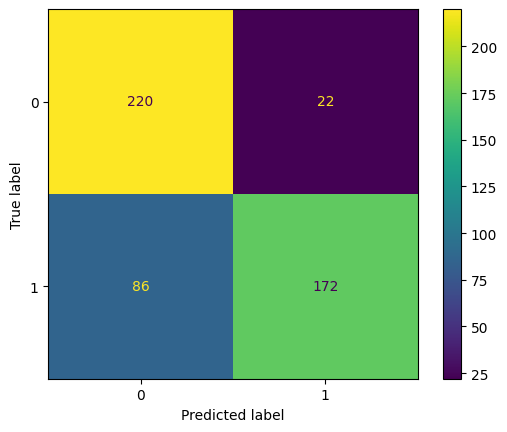

In [32]:
# Using pipeline to facilitate interpretation
pipeline_tfidf = Pipeline([
    ('vectorize', CountVectorizer(max_features=30000, analyzer='word', stop_words=None)),
    ('tfidf_analysis', TfidfTransformer()),
    ('clf_NB', MultinomialNB()),
])

pipeline_tfidf.fit(train_texts_splt, train_labels_splt)
val_pred_tfidf = pipeline_tfidf.predict(val_texts)

print("Classification Report:")
print(classification_report(val_labels, val_pred_tfidf))

classes = pipeline_tfidf.named_steps['clf_NB'].classes_

conf_mat = confusion_matrix(val_labels, val_pred_tfidf, labels=classes)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=classes)
disp.plot()

## IV - More pre-processing: getting vocabularies

For more flexibility, we will implement separately a function returning the vocabulary. Here we will have to be able to control its size, either by indicating a **maximum number of words**, or a **minimum number of occurrences** to take the words into account. **We add, at the end, an "unknown" word that will replace all the words that do not appear in our "limited" vocabulary**.
<div class='alert alert-block alert-info'>
            Code:</div>

In [35]:
def vocabulary(corpus, count_threshold=0, voc_threshold=10000):
    """
    Function using word counts to build a vocabulary - can be improved with a second parameter for
    setting a frequency threshold
    Params:
        corpus (list of strings): corpus of sentences
        count_threshold (int): number of occurrences necessary for a word to be included in the vocabulary
        voc_threshold (int): maximum size of the vocabulary. Use "0" to indicate no limit
    Returns:
        vocabulary (dictionary): keys: list of distinct words across the corpus
                                 values: indexes corresponding to each word sorted by frequency
        vocabulary_word_counts (dictionary): keys: list of distinct words across the corpus
                                             values: corresponding counts of words in the corpus
    """
    word_counts = {}
    for sent in corpus:
        # Count word frequencies
        for word in sent.split():
            word_counts[word] = word_counts.get(word, 0) + 1

    # Filter according to count_threshold
    filtered_word_counts = {word: count for word, count in word_counts.items() if count >= count_threshold}

    # Extract the words according to frequency
    sorted_words = sorted(filtered_word_counts, key=filtered_word_counts.get, reverse=True)

    # Remove the words above voc_threshold
    if voc_threshold > 0:
        filtered_words = sorted_words[:voc_threshold]
    else:
        filtered_words = sorted_words

    # Add UNK
    words = filtered_words + ['UNK']

    # Create vocabulary from "words"
    vocabulary = {word: index for index, word in enumerate(words)}

    return vocabulary, {word: filtered_word_counts.get(word, 0) for word in vocabulary}

In [37]:
# Example for testing:

corpus = ['I walked down down the boulevard',
          'I walked down the avenue',
          'I ran down the boulevard',
          'I walk down the city',
          'I walk down the the avenue']

voc, counts = vocabulary(corpus, count_threshold = 3)
print("Considering count_threshold = 3:")
print("--> Vocabulary:", voc)
print("-->     Counts:", counts)

# We expect something like this:
# (In this example, we don't count 'UNK' unknown words, but you can if you want to. 
# How useful it may be depends on the data -> we will use the counts later with word2vec, keep that in mind) 
#  {'down': 0, 'the': 1, 'i': 2, 'UNK': 3}
#  {'down': 6, 'the': 6, 'i': 5, 'UNK': 0}

voc, counts = vocabulary(corpus)
print("\nDisconsidering the count_threshold:")
print("--> Vocabulary:", voc)
print("-->     Counts:", counts)

# We expect something like this:
#  {'down': 0, 'the': 1, 'i': 2, 'walked': 3, 'boulevard': 4, 'avenue': 5, 'walk': 6, 'ran': 7, 'city': 8, 'UNK': 9}
#  {'down': 6, 'the': 6, 'i': 5, 'walked': 2, 'boulevard': 2, 'avenue': 2, 'walk': 2, 'ran': 1, 'city': 1, 'UNK': 0}

Considering count_threshold = 3:
--> Vocabulary: {'down': 0, 'the': 1, 'I': 2, 'UNK': 3}
-->     Counts: {'down': 6, 'the': 6, 'I': 5, 'UNK': 0}

Disconsidering the count_threshold:
--> Vocabulary: {'down': 0, 'the': 1, 'I': 2, 'walked': 3, 'boulevard': 4, 'avenue': 5, 'walk': 6, 'ran': 7, 'city': 8, 'UNK': 9}
-->     Counts: {'down': 6, 'the': 6, 'I': 5, 'walked': 2, 'boulevard': 2, 'avenue': 2, 'walk': 2, 'ran': 1, 'city': 1, 'UNK': 0}


### Quick study of the data

We would like to get an idea of what's in these film reviews. So we'll get the vocabulary (in full) and represent the frequencies of the words, in order (be careful, you'll have to use a logarithmic scale): we should find back Zipf's law. This will give us an idea of the size of the vocabulary we will be able to choose: it's a matter of making a compromise between the necessary resources (size of the objects in memory) and the amount of information we can get from them (rare words can bring a lot of information, but it's difficult to learn good representations of them, because they are rare!).  

<div class='alert alert-block alert-info'>
            Code:</div>

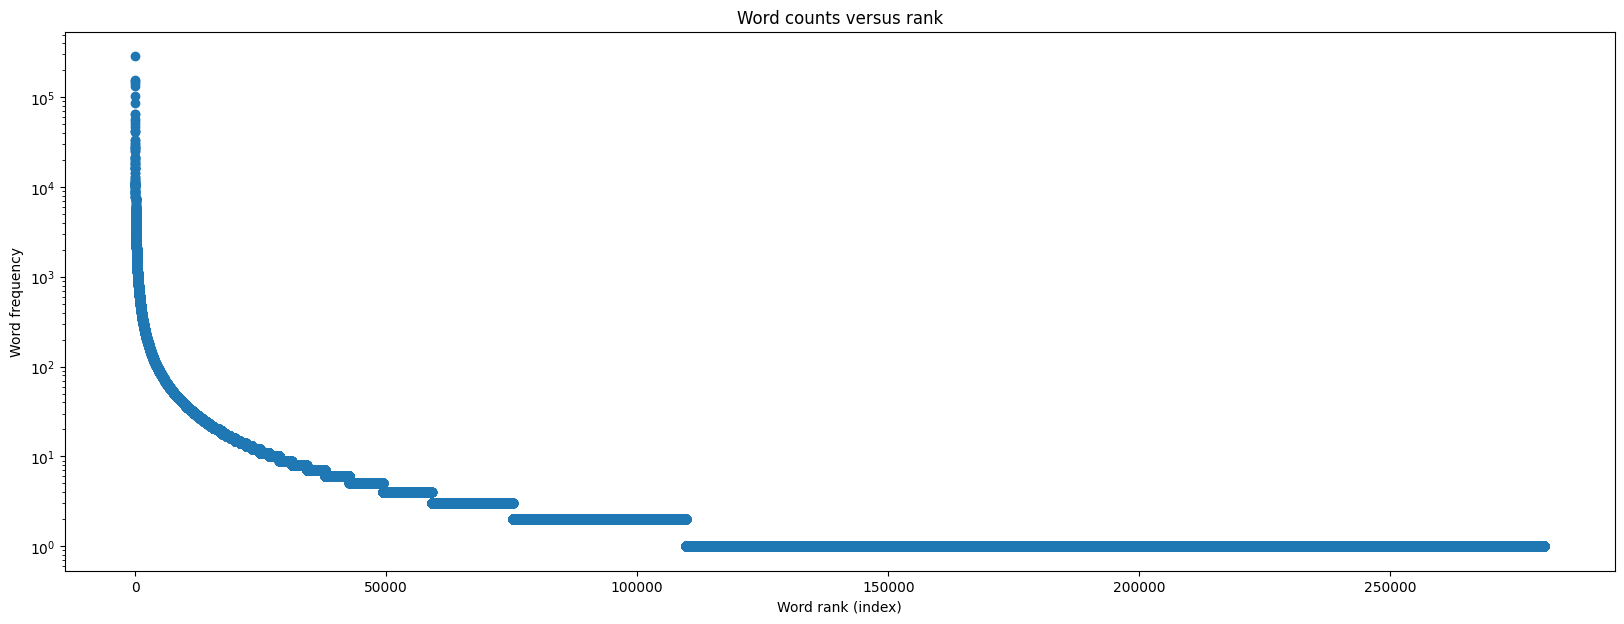

Vocabulary size: 280618


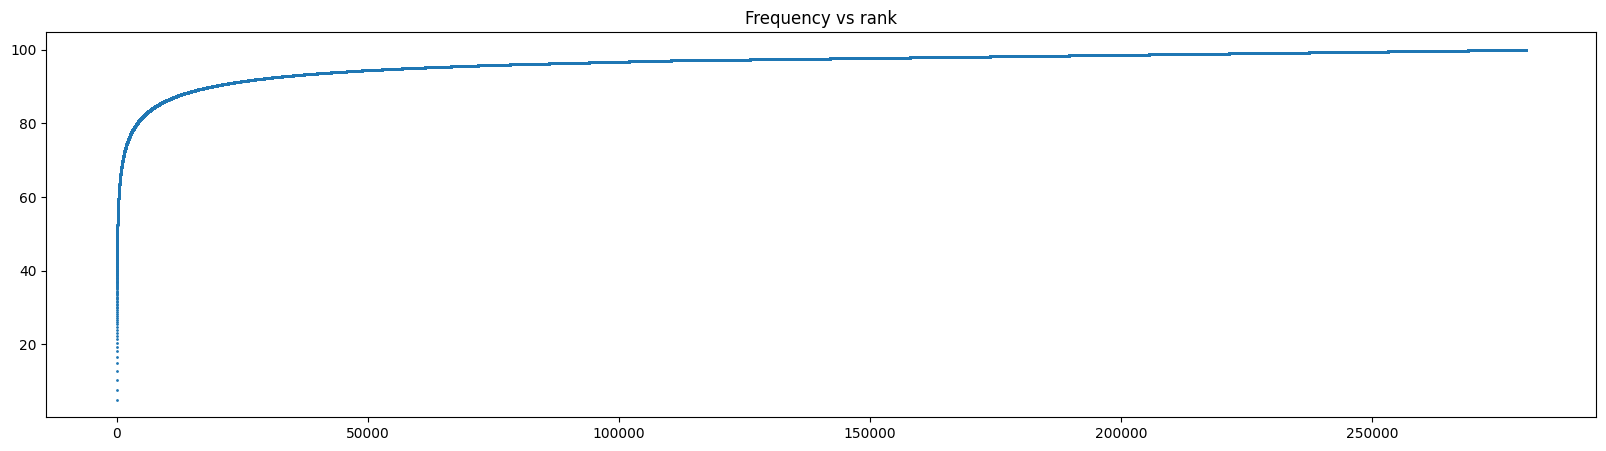

The top 40000 most frequent words represent 93.56% of the data.


In [40]:
import matplotlib.pyplot as plt

# We would like to display the curve of word frequencies given their rank (index) in the vocabulary
vocab, word_counts = vocabulary(train_texts, voc_threshold=1000000)

# Get the word frequencies and ranks
word_frequencies = list(word_counts.values())
ranks = list(range(len(word_frequencies)))

# We can for example use the function plt.scatter()
plt.figure(figsize=(20, 7), dpi=100)
plt.title('Word counts versus rank')
plt.scatter(ranks, word_frequencies)
plt.yscale('log')
plt.xlabel('Word rank (index)')
plt.ylabel('Word frequency')
plt.show()

# We would like to know how much of the data is represented by the 'k' most frequent words
print('Vocabulary size: %i' % len(vocab))

def top_frequent_words(freq, k):
    return np.sum(sorted(freq[:k] , reverse=True)) / np.sum(freq)

k = 40000
sorted_frequencies = sorted(word_frequencies, reverse=True)
total_frequency = sum(sorted_frequencies)
cumulative_sum = sum(sorted_frequencies[:k])
percentage = (cumulative_sum / total_frequency) * 100

k_frequencies = top_frequent_words(word_frequencies, k)
plt.figure(figsize=(20,5))
plt.title('Frequency vs rank')
plt.scatter(ranks, np.cumsum(word_frequencies) / np.sum(word_frequencies) * 100, s=1)
plt.show()

print(f"The top {k} most frequent words represent {percentage:.2f}% of the data.")

<div class='alert alert-block alert-warning'>
            Question:</div>
            
Word2vec's implementation cuts the vocabulary size by using **only words with at least 5 occurences**, by default. What vocabulary size would it give here ? Does it seem like a good compromise, looking at the graph ? 

**Answer:** 

Based on the graphs and the data we have got, using a count_threshold of 5 reduces the vocabulary size from 280,000 words to 49,000 words. In the first vocabulary, the 40,000 most important words were representing 93.5% of the information. So, as we got a filtered vocabulary with around 49,000 words, we are sure that this is a good compromise, as we reduced the number of words by almost 6 times and we still getting more than 93.5% of the data. Finally, by filtering out less frequent words, we can reduce the size of the vocabulary while still capturing a significant portion of the data. This could also optimize the time to process this vocabulary afterwards.


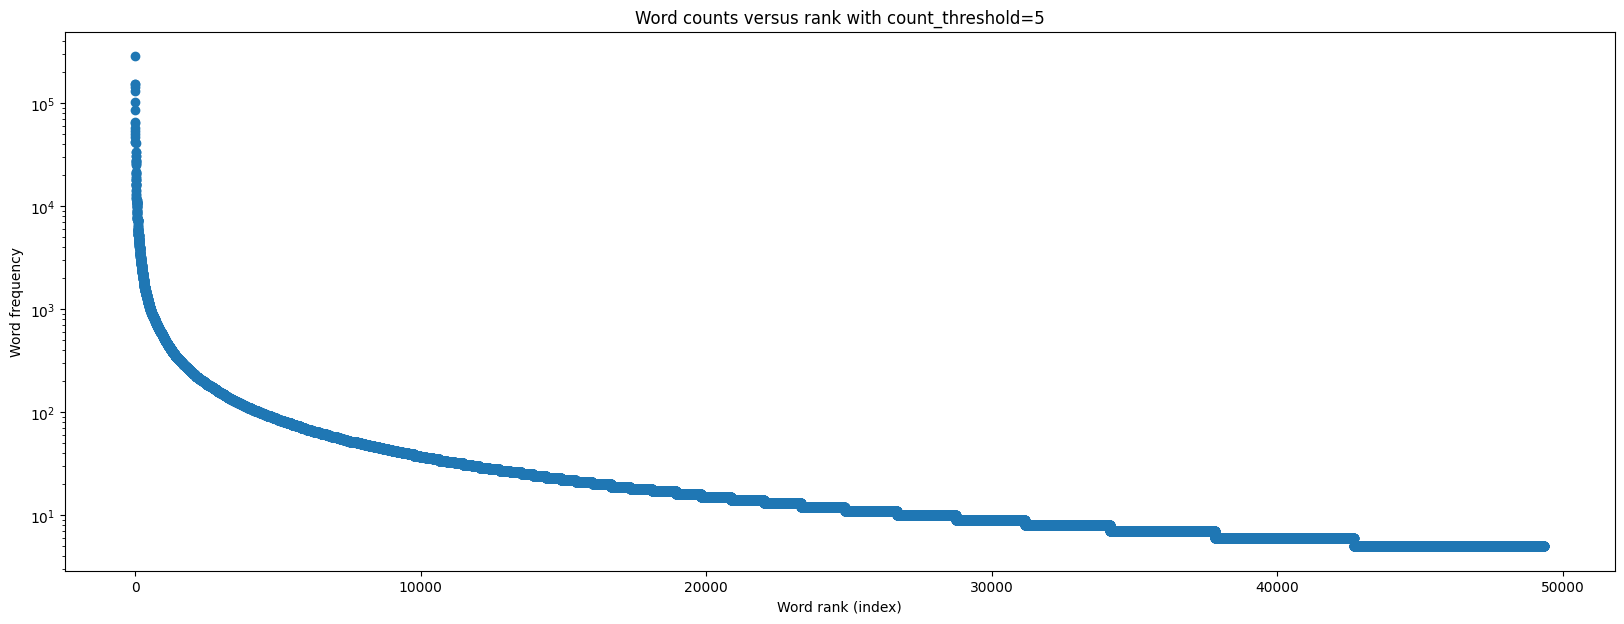

Vocabulary size: 49346


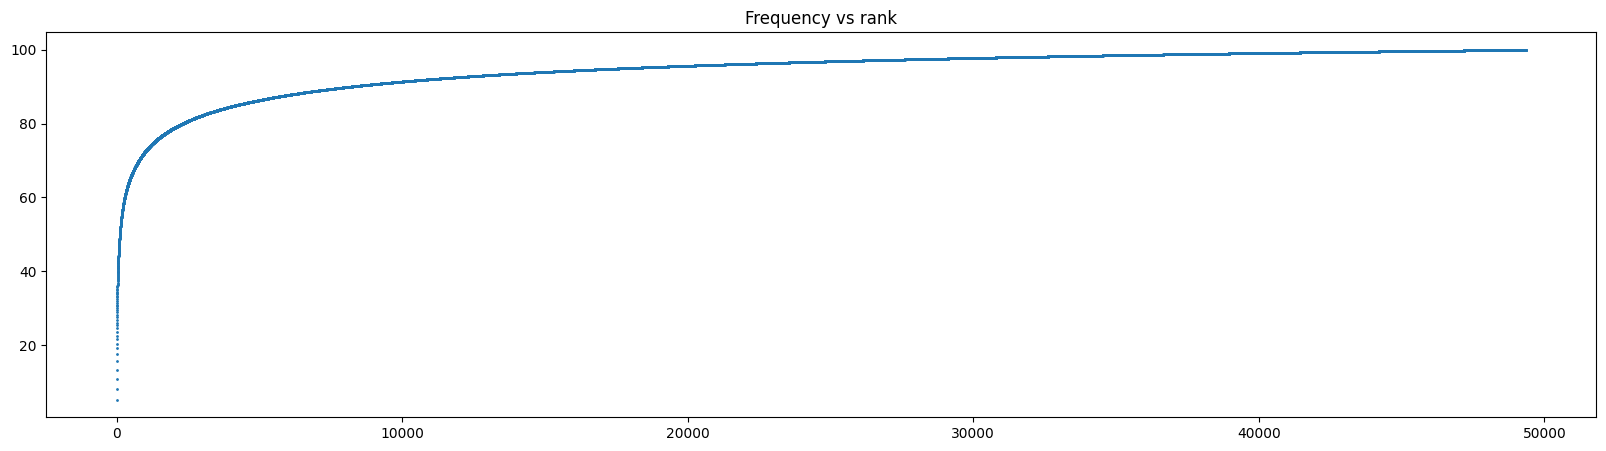

The top 40000 most frequent words represent 99.10% of the data.


In [41]:

vocab_5_occur, word_counts = vocabulary(train_texts, count_threshold=5, voc_threshold=1000000)
word_frequencies = list(word_counts.values())
ranks = list(range(len(word_frequencies)))

plt.figure(figsize=(20, 7), dpi=100)
plt.title('Word counts versus rank with count_threshold=5')
plt.scatter(ranks, word_frequencies)
plt.yscale('log')
plt.xlabel('Word rank (index)')
plt.ylabel('Word frequency')
plt.show()

k = 40000
sorted_frequencies = sorted(word_frequencies, reverse=True)

total_frequency = sum(sorted_frequencies)
cumulative_sum = sum(sorted_frequencies[:k])
percentage = (cumulative_sum / total_frequency) * 100

print('Vocabulary size: %i' % len(vocab_5_occur))

k = 40000
sorted_frequencies = sorted(word_frequencies, reverse=True)
total_frequency = sum(sorted_frequencies)
cumulative_sum = sum(sorted_frequencies[:k])
percentage = (cumulative_sum / total_frequency) * 100

k_frequencies = top_frequent_words(word_frequencies, k)
plt.figure(figsize=(20,5))
plt.title('Frequency vs rank')
plt.scatter(ranks, np.cumsum(word_frequencies) / np.sum(word_frequencies) * 100, s=1)
plt.show()

print(f"The top {k} most frequent words represent {percentage:.2f}% of the data.")


### With pre-processing tools from NLTK

We are now going to pre-process our textual data. **Note that this still will only be useful if we do not have a lot of training data to begin with !**

#### Stemming 

Allows to go back to the root of a word: you can group different words around the same root, which facilitates generalization.

Use:
```from nltk import SnowballStemmer```

In [42]:
from nltk import SnowballStemmer
stemmer = SnowballStemmer("english")

**Example:**

In [43]:
words = ['singers', 'cat', 'generalization', 'philosophy', 'psychology', 'philosopher']
for word in words:
    print('word : %s ; stemmed : %s' %(word, stemmer.stem(word)))

word : singers ; stemmed : singer
word : cat ; stemmed : cat
word : generalization ; stemmed : general
word : philosophy ; stemmed : philosophi
word : psychology ; stemmed : psycholog
word : philosopher ; stemmed : philosoph


**Data transformation:**

<div class='alert alert-block alert-info'>
            Code:</div>

In [44]:
def stem(texts):
    stemmed_texts = []
    for text in texts:
        stemmed_text = []
        for word in text.split():
            stemmed_word = stemmer.stem(word)
            stemmed_text.append(stemmed_word)
        stemmed_texts.append(' '.join(stemmed_text))
    return stemmed_texts

#### Part of speech tags

To generalize, we can also use the Part of Speech (POS) of the words, which will allow us to filter out information that is potentially not useful to the model. We will retrieve the POS of the words using the functions:
```pos_tag```

In [45]:
import nltk
from nltk import pos_tag, word_tokenize

**Example:**

In [46]:
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

pos_tag(word_tokenize(('I am Sam')))

[nltk_data] Downloading package punkt to C:\Users\João
[nltk_data]     Melga\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\João Melga\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


[('I', 'PRP'), ('am', 'VBP'), ('Sam', 'NNP')]

**Data transformation:** only keep nouns, verbs, adverbs, and adjectives (```['NN', 'VB', 'ADJ', 'RB']```) for our model.

<div class='alert alert-block alert-info'>
            Code:</div>

In [47]:
def pos_tag_filter(X, good_tags=['NN', 'VB', 'ADJ', 'RB']):
    filtered_X = []
    for sentence in X:
        tagged_sentence = pos_tag(word_tokenize(sentence))
        filtered_sentence = str([word for word, tag in tagged_sentence if tag in good_tags])
        filtered_X.append(filtered_sentence)
    return filtered_X

### Application

<div class='alert alert-block alert-warning'>
            Question:</div>

Re-draw the Zipf distribution of our data **after reducing their vocabulary with these functions**. How is it affected ? How do you think it could affect results here ? 

**Answer:**

We runned 4 different analysis, the first two ones to figure out how stemm and pos_tag alone would affect our results, and the last two ones were, first, the pos_tag followed by the stamm and, the last one, the stemm followed by the post.

For the stemm, we have got a vocabulary size around 42,000 and execution time of around 5s. We could find that stemm is a fast method compared the to other ones.

For the pos_tag, the vocabulary size was of around 13,500 and exceution time of around 22s. Even pos_tag took more time to execute, it reduced the vocabulary size around 3 times more than the stemm.

For the pos_tag followed by the stemm, we ended up with a vocabulary size of 12,900 and execution time of 24s. The result here is that the stemm doesn't promote big reduction of the vocabulary when used after the pos_tag, which is not true for the opposite case (stemm followed by pos_tag).

Lastly, for the stemm followed by the pos_tag, a vocabulary size of 20,000 and 26s to execute it.
        
<div class='alert alert-block alert-info'>
            Code:</div>        

Fisrt we tried to apply only the stemm:

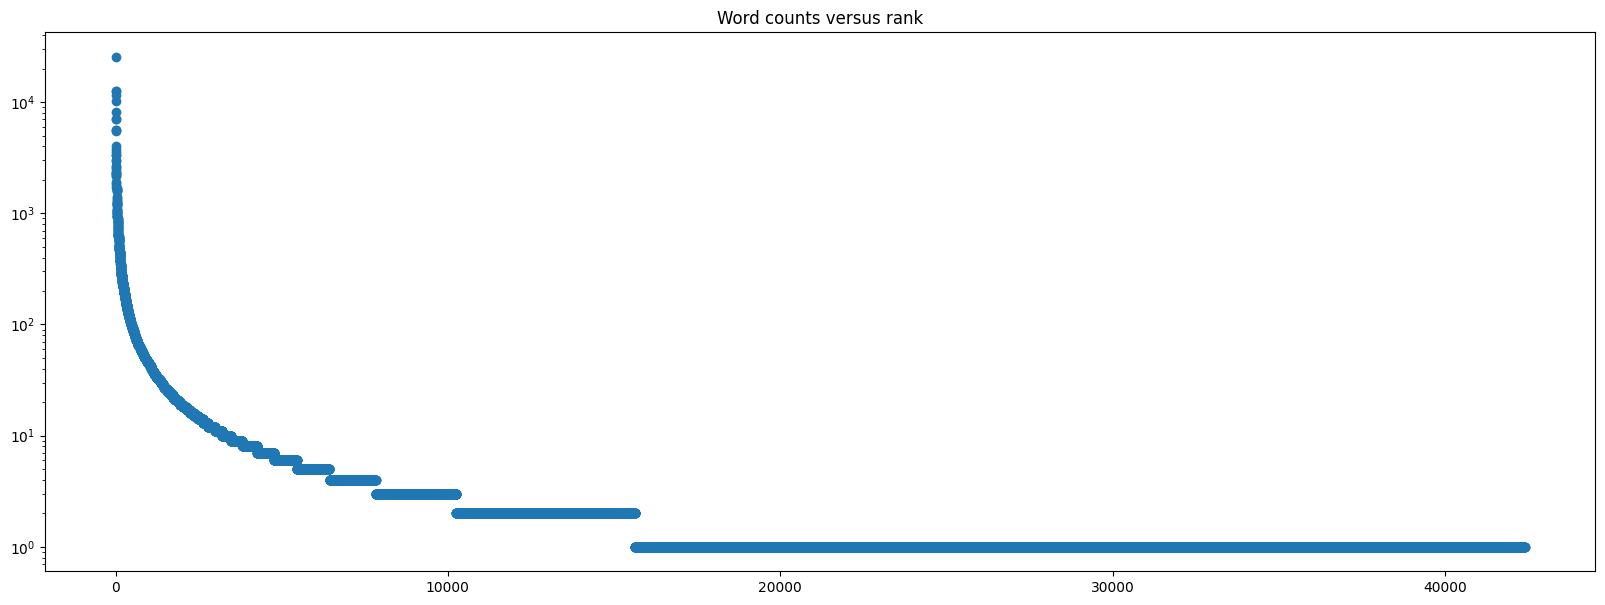

Vocabulary size: 42402
The top 5000 most frequent words represent 87.36% of the data.


In [48]:
stemmed_train_texts = stem(train_texts_splt)
# pos_tagged_train_texts = pos_tag_filter(stemmed_train_texts)

vocab, word_counts = vocabulary(stemmed_train_texts, voc_threshold=1000000)
word_frequencies = list(word_counts.values())
ranks = list(range(len(word_frequencies)))

plt.figure(figsize=(20, 7), dpi=100)
plt.title('Word counts versus rank')
plt.scatter(ranks, word_frequencies)
plt.yscale('log')
plt.show()

k = 5000
sorted_frequencies = sorted(word_frequencies, reverse=True)

total_frequency = sum(sorted_frequencies)
cumulative_sum = sum(sorted_frequencies[:k])
percentage = (cumulative_sum / total_frequency) * 100

print('Vocabulary size: %i' % len(vocab))
print(f"The top {k} most frequent words represent {percentage:.2f}% of the data.")

Now we apply only the pos_tag:

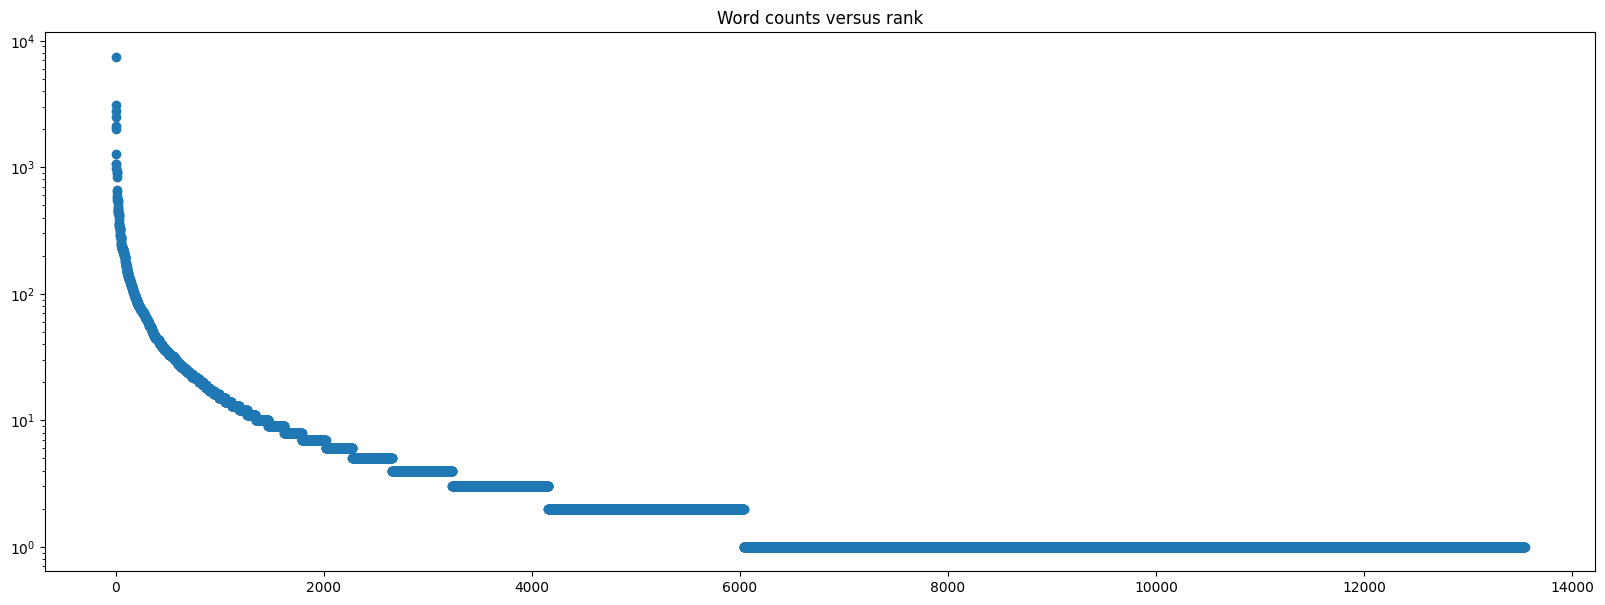

Vocabulary size: 13545
The top 5000 most frequent words represent 92.26% of the data.


In [49]:
pos_tagged_train_texts = pos_tag_filter(train_texts_splt)

vocab, word_counts = vocabulary(pos_tagged_train_texts, voc_threshold=1000000)
word_frequencies = list(word_counts.values())
ranks = list(range(len(word_frequencies)))

plt.figure(figsize=(20, 7), dpi=100)
plt.title('Word counts versus rank')
plt.scatter(ranks, word_frequencies)
plt.yscale('log')
plt.show()

k = 5000
sorted_frequencies = sorted(word_frequencies, reverse=True)

total_frequency = sum(sorted_frequencies)
cumulative_sum = sum(sorted_frequencies[:k])
percentage = (cumulative_sum / total_frequency) * 100

print('Vocabulary size: %i' % len(vocab))
print(f"The top {k} most frequent words represent {percentage:.2f}% of the data.")

Applying pos_tag followed by stemm:

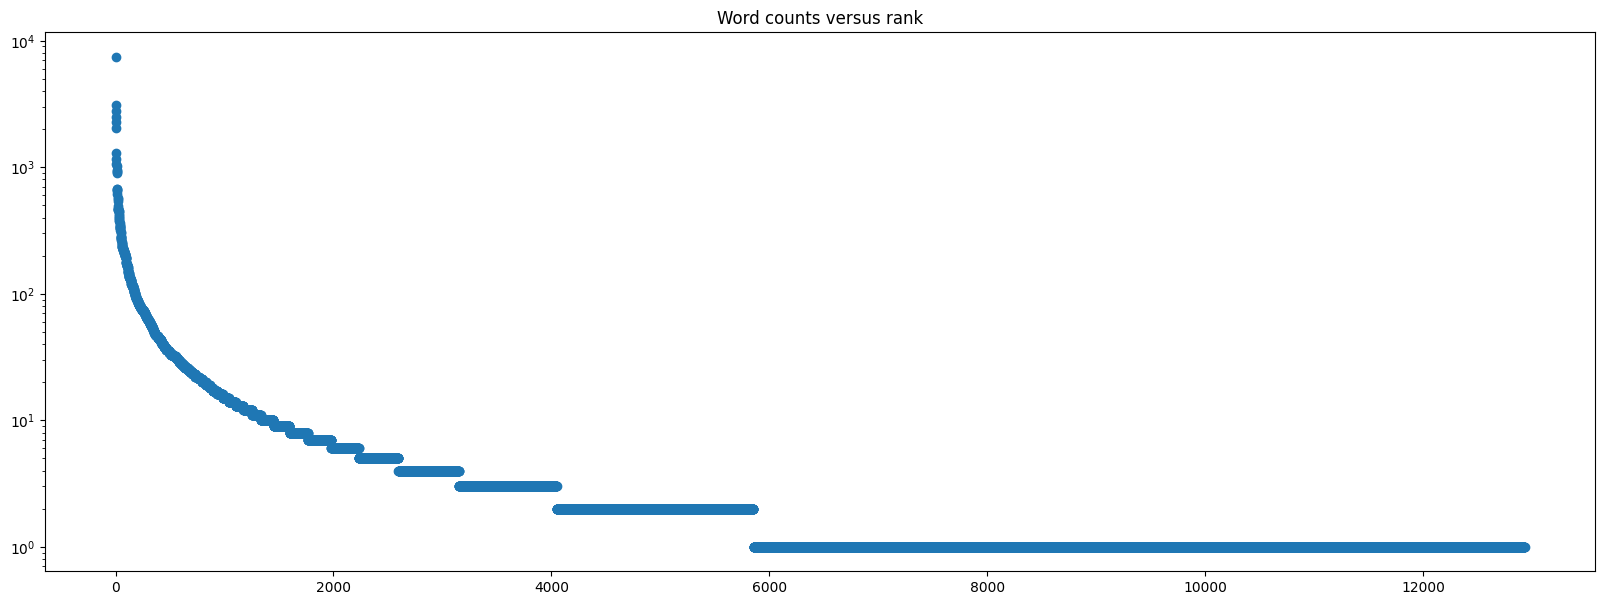

Vocabulary size: 12933
The top 5000 most frequent words represent 92.90% of the data.


In [50]:
pos_tagged_train_texts = pos_tag_filter(train_texts_splt)
stemmed_train_texts = stem(pos_tagged_train_texts)

vocab, word_counts = vocabulary(stemmed_train_texts, voc_threshold=1000000)
word_frequencies = list(word_counts.values())
ranks = list(range(len(word_frequencies)))

plt.figure(figsize=(20, 7), dpi=100)
plt.title('Word counts versus rank')
plt.scatter(ranks, word_frequencies)
plt.yscale('log')
plt.show()

k = 5000
sorted_frequencies = sorted(word_frequencies, reverse=True)

total_frequency = sum(sorted_frequencies)
cumulative_sum = sum(sorted_frequencies[:k])
percentage = (cumulative_sum / total_frequency) * 100

print('Vocabulary size: %i' % len(vocab))
print(f"The top {k} most frequent words represent {percentage:.2f}% of the data.")

Finnaly, applying stemm followed by the pos_tag:

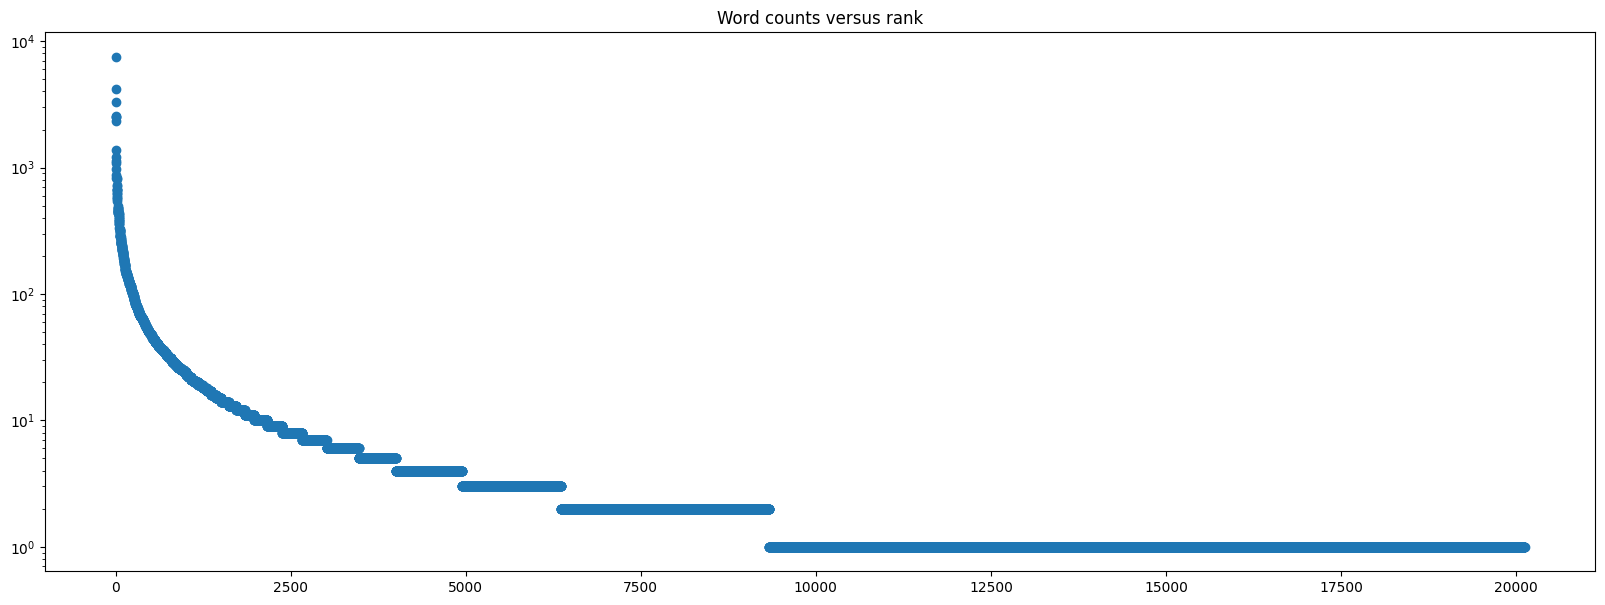

Vocabulary size: 20123
The top 5000 most frequent words represent 88.03% of the data.


In [51]:
stemmed_train_texts = stem(train_texts_splt)
pos_tagged_train_texts = pos_tag_filter(stemmed_train_texts)

vocab, word_counts = vocabulary(pos_tagged_train_texts, voc_threshold=1000000)
word_frequencies = list(word_counts.values())
ranks = list(range(len(word_frequencies)))

plt.figure(figsize=(20, 7), dpi=100)
plt.title('Word counts versus rank')
plt.scatter(ranks, word_frequencies)
plt.yscale('log')
plt.show()

k = 5000
sorted_frequencies = sorted(word_frequencies, reverse=True)

total_frequency = sum(sorted_frequencies)
cumulative_sum = sum(sorted_frequencies[:k])
percentage = (cumulative_sum / total_frequency) * 100

print('Vocabulary size: %i' % len(vocab))
print(f"The top {k} most frequent words represent {percentage:.2f}% of the data.")